# Denoising scRNA-seq using DCA

In [1]:
import os
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.4.3'  # modify path accordingly

## scRNA-seq Simulation using Splatter R package and rpy2

In [2]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

C:\Users\maygb\miniconda3\envs\new_env\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


### Simulate two groups using Splatter

In [3]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo -o dropout

# make sure that splatter is installed: https://github.com/Oshlack/splatter
library(splatter)

simulate <- function(nGroups=2, nGenes=200, batchCells=6000, dropout=5)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups

    # new splatter requires dropout.type
    if ('dropout.type' %in% slotNames(newSplatParams())) {
        if (dropout)
            dropout.type <- 'experiment'
        else
            dropout.type <- 'none'
        
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.type=dropout.type, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)

    } else {
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.present=!dropout, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)        
    }

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- as.matrix(assays(sim)$Dropout)
    mode(dropout) <- 'integer'
    dropout    <- as.data.frame(t(dropout))

    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts,
         dropout=dropout)
}

sim <- simulate()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts
dropout <- sim$dropout

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: 'MatrixGenerics'

The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

## Generate AnnData objects and analyze in Scanpy

In [4]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import scanpy as sc
import pandas as pd
import scipy as sp
from dca.api import dca, normalize

from sklearn.metrics import silhouette_score

sc.settings.set_figure_params(dpi=120)

In [5]:
sim_raw = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
sim_raw.obs_names = cellinfo.Cell
sim_raw.var_names = geneinfo.Gene
sc.pp.filter_genes(sim_raw, min_counts=1)

# remove zero-genes from dropout data frame too
dropout_gt = dropout.loc[:, sim_raw.var_names].values

sim_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
sim_true.obs_names = cellinfo.Cell
sim_true.var_names = geneinfo.Gene
sim_true = sim_true[:, sim_raw.var_names].copy()
sim_true

sim_raw_norm = sim_raw.copy()
sc.pp.normalize_total(sim_raw_norm)
sc.pp.log1p(sim_raw_norm)
sc.pp.pca(sim_raw_norm)

sim_true_norm = sim_true.copy()
sc.pp.normalize_total(sim_true_norm)
sc.pp.log1p(sim_true_norm)
sc.pp.pca(sim_true_norm)

print(dropout_gt[:10, :10])
print(sim_raw)
print(sim_true)

[[1 0 1 1 1 1 1 0 1 0]
 [1 1 0 1 1 0 1 0 1 1]
 [1 1 0 1 1 0 1 1 0 1]
 [1 1 1 1 1 0 1 0 1 1]
 [1 1 1 1 1 0 1 0 0 1]
 [1 0 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 0 1 0 1 1]
 [1 1 1 0 1 0 1 0 0 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 0 1 1 1 1 1 1 0 1]]
AnnData object with n_obs × n_vars = 6000 × 200
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'
AnnData object with n_obs × n_vars = 6000 × 200
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2'


## Denoise simulated data

In [6]:
%%time

dca_zinb = dca(sim_raw, threads=1, copy=True, log1p=False, return_info=True, verbose=False, random_state=50) # change random_state

dca_zinb_norm = dca_zinb.copy()
sc.pp.normalize_total(dca_zinb_norm)
sc.pp.log1p(dca_zinb_norm)
sc.pp.pca(dca_zinb_norm)

dca: Successfully preprocessed 200 genes and 6000 cells.



2025-03-05 20:42:04,695 [WARNING] From C:\Users\maygb\miniconda3\envs\new_env\lib\site-packages\dca\train.py:41: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

C:\Users\maygb\miniconda3\envs\new_env\lib\site-packages\tensorflow\python\keras\engine\training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
CPU times: total: 3min 10s
Wall time: 3min 26s


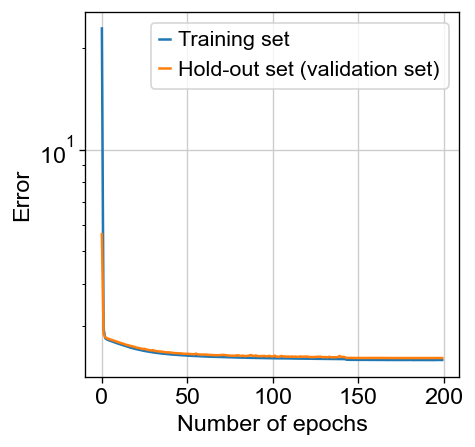

In [7]:
valloss = dca_zinb.uns['dca_loss_history']['val_loss']
loss = dca_zinb.uns['dca_loss_history']['loss']
i = range(len(loss))

f, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(i, loss, i, valloss)
ax.semilogy()
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Error')
plt.legend(['Training set', 'Hold-out set (validation set)'])
plt.show()

In [8]:
dca_mse = dca(sim_raw, ae_type='normal', threads=1, copy=True, normalize_per_cell=False, scale=False,
              training_kwds={'use_raw_as_output': False}, random_state=50)

dca_mse.X = np.exp(dca_mse.X) # bring MSE output back to normal scale

dca: Successfully preprocessed 200 genes and 6000 cells.
dca: Calculating reconstructions...


In [9]:
dca_mse_norm = dca_mse.copy()

sc.pp.normalize_total(dca_mse_norm)
sc.pp.log1p(dca_mse_norm)
sc.pp.pca(dca_mse_norm)

C:\Users\maygb\miniconda3\envs\new_env\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Batch' as categorical
C:\Users\maygb\miniconda3\envs\new_env\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Batch' as categorical
C:\Users\maygb\miniconda3\envs\new_env\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reo

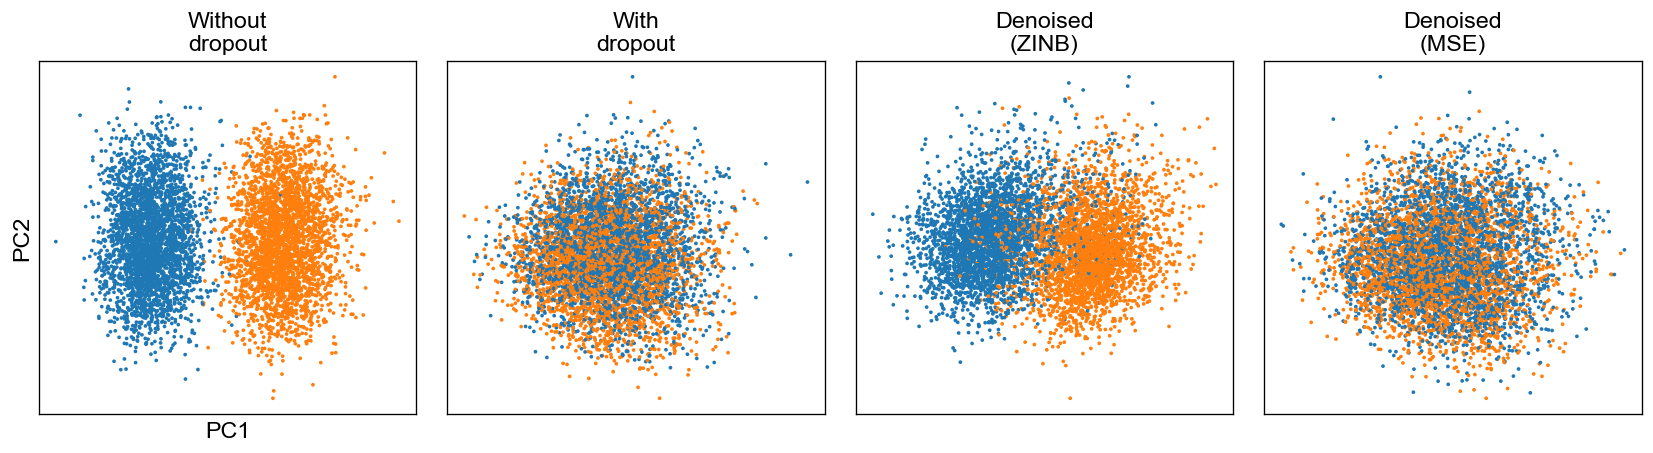

In [10]:
adatas = [sim_true_norm, sim_raw_norm, dca_zinb_norm, dca_mse_norm]
adata_labels = ['Without\ndropout', 'With\ndropout', 'Denoised\n(ZINB)', 'Denoised\n(MSE)']

fig, axs = plt.subplots(1, len(adatas), figsize=(14,4))

for i, (lbl, ad, ax) in enumerate(zip(adata_labels, adatas, axs)):
    sc.pl.pca_scatter(ad, color='Group', size=20, title=lbl, ax=ax, show=False, legend_loc='none')
    if i!=0: 
        ax.set_xlabel('')
        ax.set_ylabel('')
        
plt.tight_layout()
#plt.savefig('two-group-pca.pdf')

C:\Users\maygb\AppData\Local\Temp\ipykernel_948\3550195706.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + adata_labels)


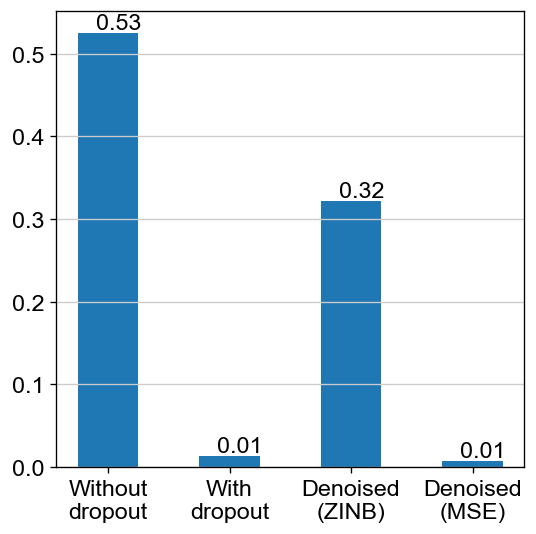

In [11]:
sils = np.array([silhouette_score(ad.obsm['X_pca'][:, :2], 
                 ad.obs.Group) for ad in adatas])

f, ax = plt.subplots(figsize=(5,5))
ax.grid(axis='x')

# Choose the width of each bar and their positions
width = 5
x_pos = [10,20,30,40]
 
# Make the plot
ax.bar(x_pos, sils, width=width)
ax.set_xticklabels([''] + adata_labels)

for x, t in zip(x_pos, sils):
    ax.text(x-1, t+0.005, '%.2f' % t)

C:\Users\maygb\miniconda3\envs\new_env\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


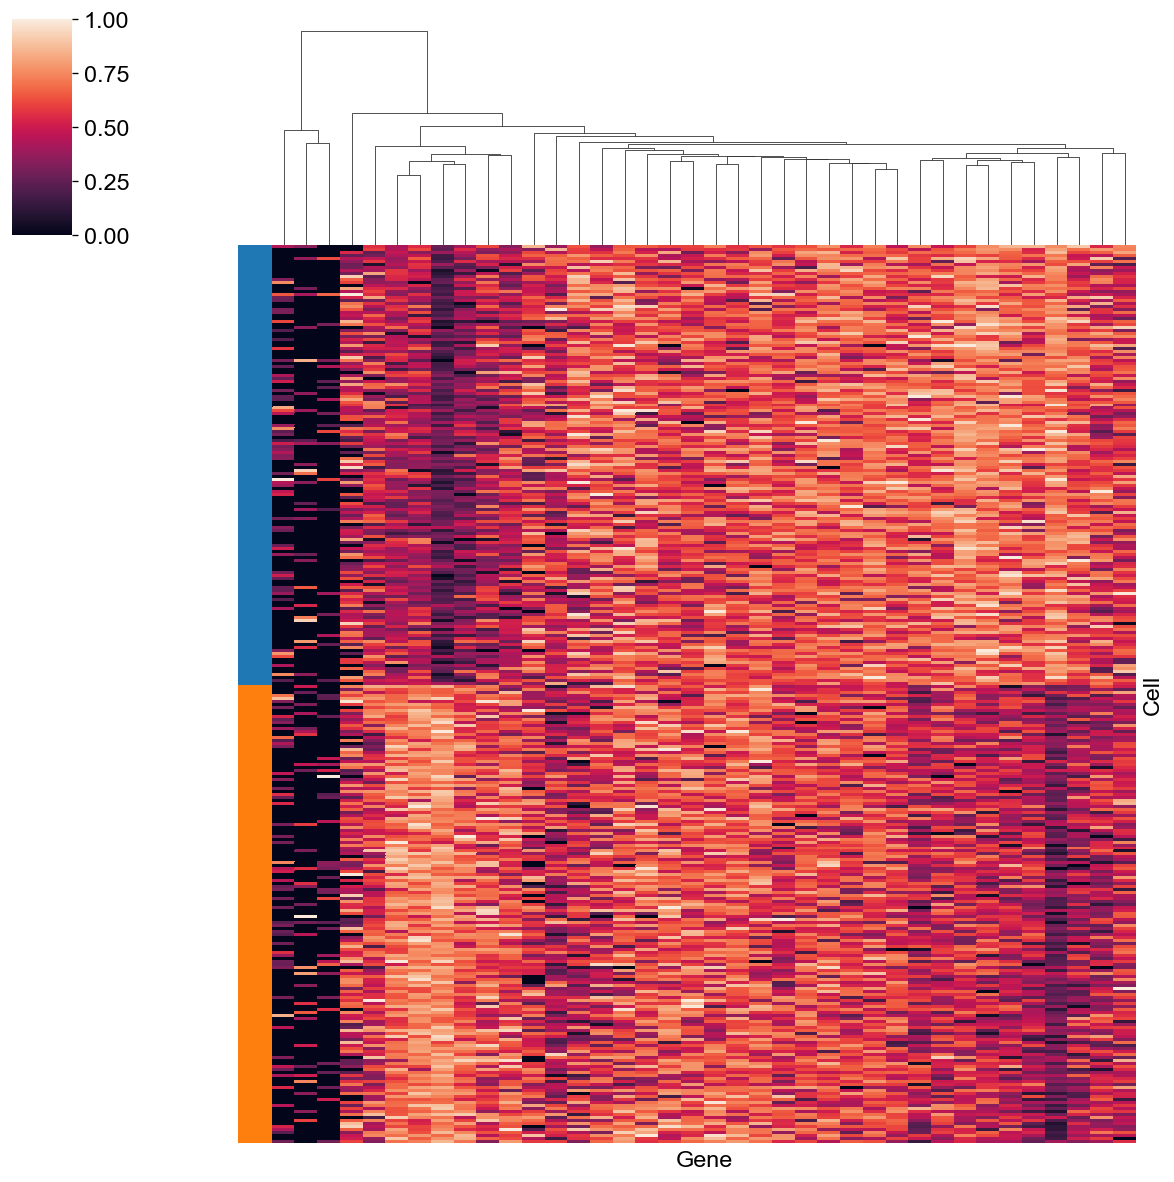

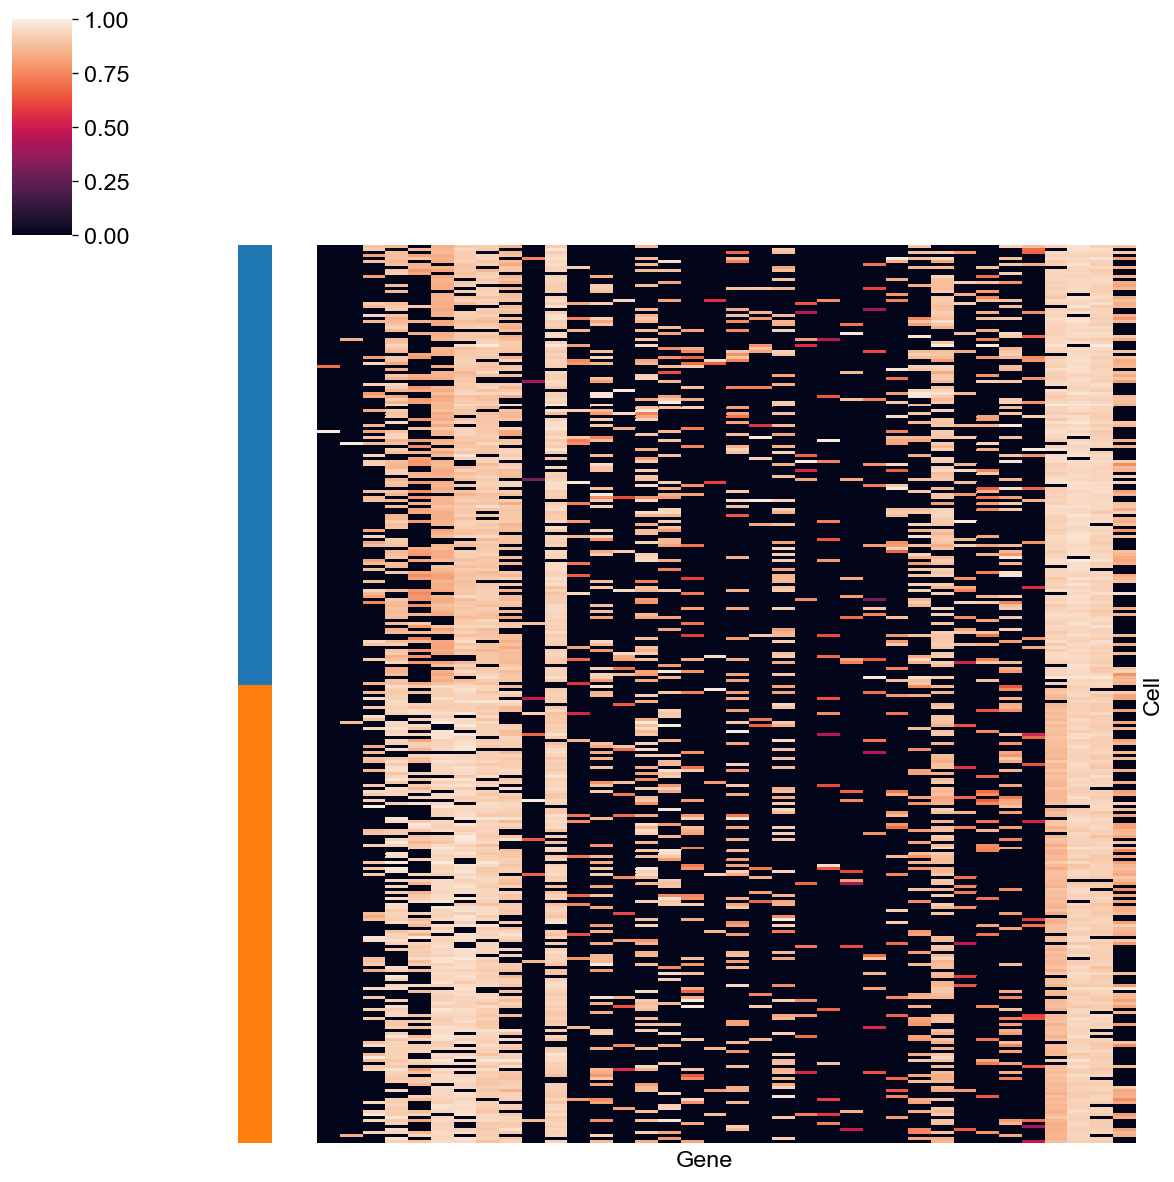

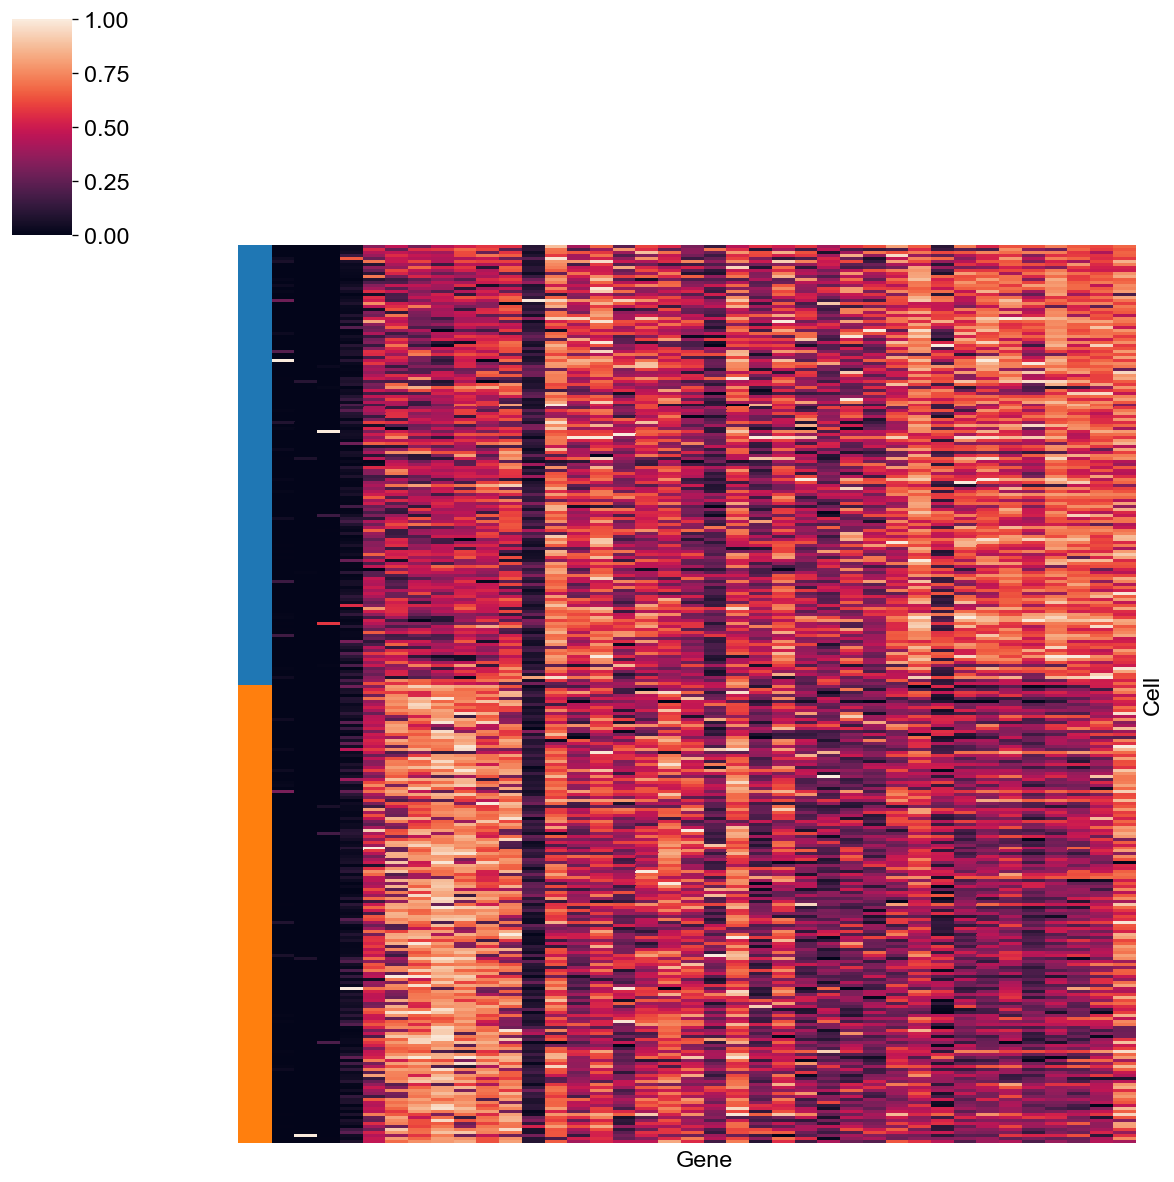

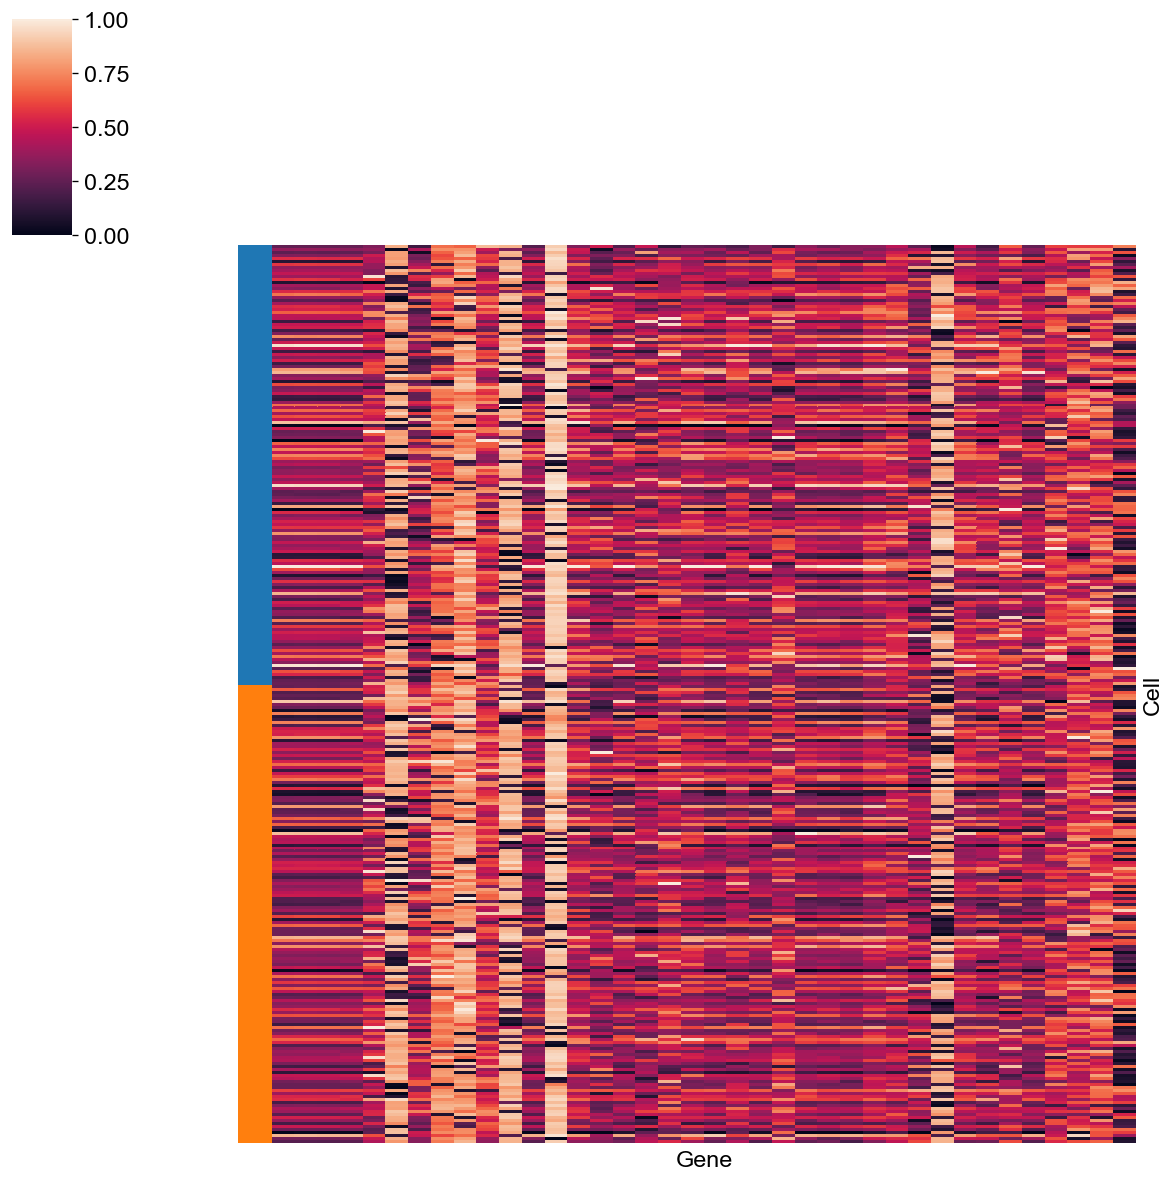

In [12]:
de_genes = np.where(sim_true_norm.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)[0]

obs_idx = np.random.choice(list(range(sim_raw_norm.n_obs)), 300, replace=False)
idx = np.argsort(sim_true_norm.obs.Group.values[obs_idx])
obs_idx = obs_idx[idx]

ax = sc.pl.clustermap(sim_true_norm[obs_idx, de_genes], 'Group', use_raw=False,
                      standard_scale=1, row_cluster=False, show=False, xticklabels=False, yticklabels=False)
ax.ax_row_dendrogram.set_visible(False)

gene_order = ax.dendrogram_col.reordered_ind # preserve gene order from true counts to make heatmaps easily comparable
de_genes = de_genes[gene_order]

ax = sc.pl.clustermap(sim_raw_norm[obs_idx, de_genes], 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

ax = sc.pl.clustermap(dca_zinb_norm[obs_idx, de_genes], 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

ax = sc.pl.clustermap(dca_mse_norm[obs_idx, de_genes], 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

## Comparison of ZINB, NB and MSE models

In [13]:
dca_nb = dca(sim_raw, ae_type='nb-conddisp', threads=1, copy=True, log1p=False)

dca: Successfully preprocessed 200 genes and 6000 cells.
dca: Calculating reconstructions...


In [14]:
# !pip install kern_smooth
from kern_smooth import densCols

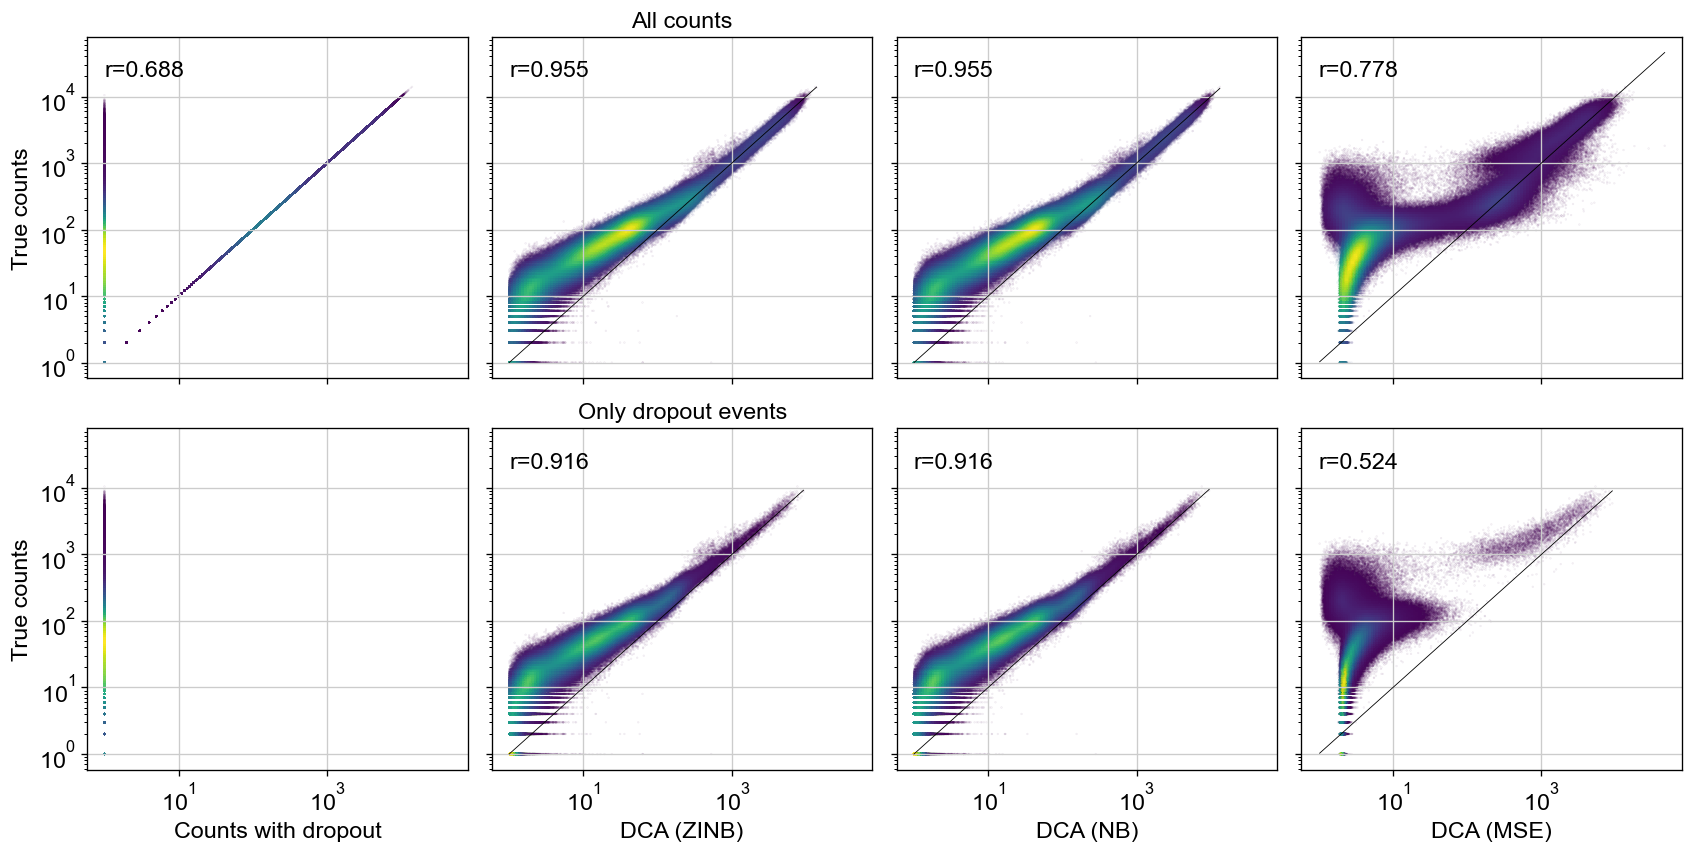

In [15]:
f, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(14,7), constrained_layout=True)

adatas_raw = [sim_raw, dca_zinb, dca_nb, dca_mse]
adata_raw_labels = ['Counts with dropout', 'DCA (ZINB)', 'DCA (NB)', 'DCA (MSE)']
true_counts = sim_true.X.flatten()+1

for i, (ax, ad, lbl) in enumerate(zip(axes[0], adatas_raw, adata_raw_labels)):
    x = ad.X.flatten()+1
    y = true_counts
    c = densCols(np.log10(x), np.log10(y))
    ax.scatter(x, y, s=0.1, alpha=0.1, c=c, marker='o')
    if i == 0: 
        ax.set_ylabel('True counts')
    else:
        ax.plot([min(x), max(x)], [min(x), max(x)], 'k-', linewidth=0.5)
    if i == 1:
        ax.set_title('All counts')        
    cor = np.corrcoef(np.log(x), np.log(y))[0, 1]
    ax.annotate(f'r={cor.round(3)}', (1, 20000))        
        
    ax.loglog()

true_dropout = true_counts[dropout_gt.flatten()==1]
for i, (ax, ad, lbl) in enumerate(zip(axes[1], adatas_raw, adata_raw_labels)):
    x = ad.X[dropout_gt==1]+1
    y = true_dropout
    c = densCols(np.log10(x), np.log10(y))
    ax.scatter(x, y, s=0.1, alpha=0.1, c=c, marker='o')

    if i==0: 
        ax.set_ylabel('True counts')
    else: 
        cor = np.corrcoef(np.log(x), np.log(y))[0, 1]
        ax.annotate(f'r={cor.round(3)}', (1, 20000))                              
        ax.plot([min(x), max(x)], [min(x), max(x)], 'k-', linewidth=0.5)
    if i == 1:
        ax.set_title('Only dropout events')        

    ax.loglog()
    ax.set_xlabel(lbl)

## Simulate six groups

In [16]:
%%R -o counts -o geneinfo -o cellinfo -o truecounts

sim <- simulate(nGroups=6, dropout=3)

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

Getting parameters...
Creating simulation object...
Simulating library sizes...
Simulating gene means...
Simulating group DE...
Simulating cell means...
Simulating BCV...
Simulating counts...
Simulating dropout (if needed)...
Sparsifying assays...
Automatically converting to sparse matrices, threshold = 0.95
Skipping 'BatchCellMeans': estimated sparse size 1.5 * dense matrix
Skipping 'BaseCellMeans': estimated sparse size 1.5 * dense matrix
Skipping 'BCV': estimated sparse size 1.5 * dense matrix
Skipping 'CellMeans': estimated sparse size 1.5 * dense matrix
Skipping 'TrueCounts': estimated sparse size 2.86 * dense matrix
Skipping 'DropProb': estimated sparse size 1.5 * dense matrix
Converting 'Dropout' to sparse matrix: estimated sparse size 0.74 * dense matrix
Skipping 'counts': estimated sparse size 1.89 * dense matrix
Done!


In [17]:
sim_raw6 = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
sim_raw6.obs_names = cellinfo.Cell
sim_raw6.var_names = geneinfo.Gene
sc.pp.filter_genes(sim_raw6, min_counts=1)

sim_true6 = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
sim_true6.obs_names = cellinfo.Cell
sim_true6.var_names = geneinfo.Gene
sim_true6 = sim_true6[:, sim_raw6.var_names].copy()
sim_true6

sim_raw_norm6 = sim_raw6.copy()
sc.pp.normalize_total(sim_raw_norm6)
sc.pp.log1p(sim_raw_norm6)
sc.pp.pca(sim_raw_norm6)
sc.pp.neighbors(sim_raw_norm6)
sc.tl.umap(sim_raw_norm6)

sim_true_norm6 = sim_true6.copy()
sc.pp.normalize_total(sim_true_norm6)
sc.pp.log1p(sim_true_norm6)
sc.pp.pca(sim_true_norm6)
sc.pp.neighbors(sim_true_norm6)
sc.tl.umap(sim_true_norm6)

print(sim_raw6)
print(sim_true6)

AnnData object with n_obs × n_vars = 6000 × 200
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'
AnnData object with n_obs × n_vars = 6000 × 200
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6'


## Denoise simulated data

In [18]:
%%time
dca_zinb6 = dca(sim_raw6, threads=1, copy=True, log1p=False, random_state=50)

dca: Successfully preprocessed 200 genes and 6000 cells.
dca: Calculating reconstructions...
CPU times: total: 2min 31s
Wall time: 3min 1s


In [19]:
dca_zinb_norm6 = dca_zinb6.copy()
sc.pp.normalize_total(dca_zinb_norm6)
sc.pp.log1p(dca_zinb_norm6)
sc.pp.pca(dca_zinb_norm6)
sc.pp.neighbors(dca_zinb_norm6)
sc.tl.umap(dca_zinb_norm6)

In [20]:
dca_mse6 = dca(sim_raw6, ae_type='normal', threads=1, copy=True, random_state=50,
               training_kwds={'use_raw_as_output': False}, normalize_per_cell=False, scale=False)

dca_mse_norm6 = dca_mse6.copy()
sc.pp.normalize_total(dca_mse_norm6)
sc.pp.pca(dca_mse_norm6)
sc.pp.neighbors(dca_mse_norm6)
sc.tl.umap(dca_mse_norm6)

dca_mse6.X = np.exp(dca_mse6.X) # bring MSE output back to normal scale

dca: Successfully preprocessed 200 genes and 6000 cells.
dca: Calculating reconstructions...


... storing 'Batch' as categorical
... storing 'Batch' as categorical
... storing 'Batch' as categorical
... storing 'Batch' as categorical


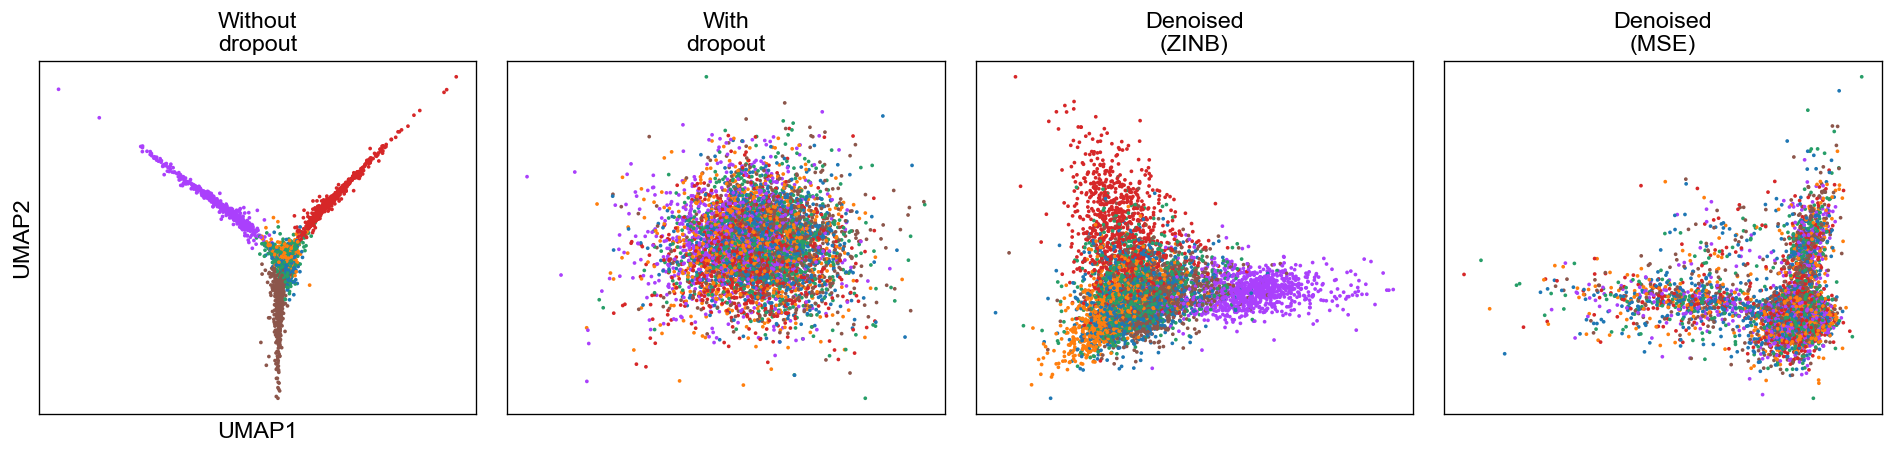

In [21]:
adatas6 = [sim_true_norm6, sim_raw_norm6, dca_zinb_norm6, dca_mse_norm6]
adata_labels6 = ['Without\ndropout', 'With\ndropout', 'Denoised\n(ZINB)', 'Denoised\n(MSE)']

fig, axs = plt.subplots(1, len(adatas6), figsize=(16,4))
for i, (lbl, ad, ax) in enumerate(zip(adata_labels6, adatas6, axs)):
    sc.pl.umap(ad, color='Group', size=20, title=lbl, ax=ax, show=False, legend_loc='none')
    if i!=0: 
        ax.set_xlabel('')
        ax.set_ylabel('')
        
plt.tight_layout()

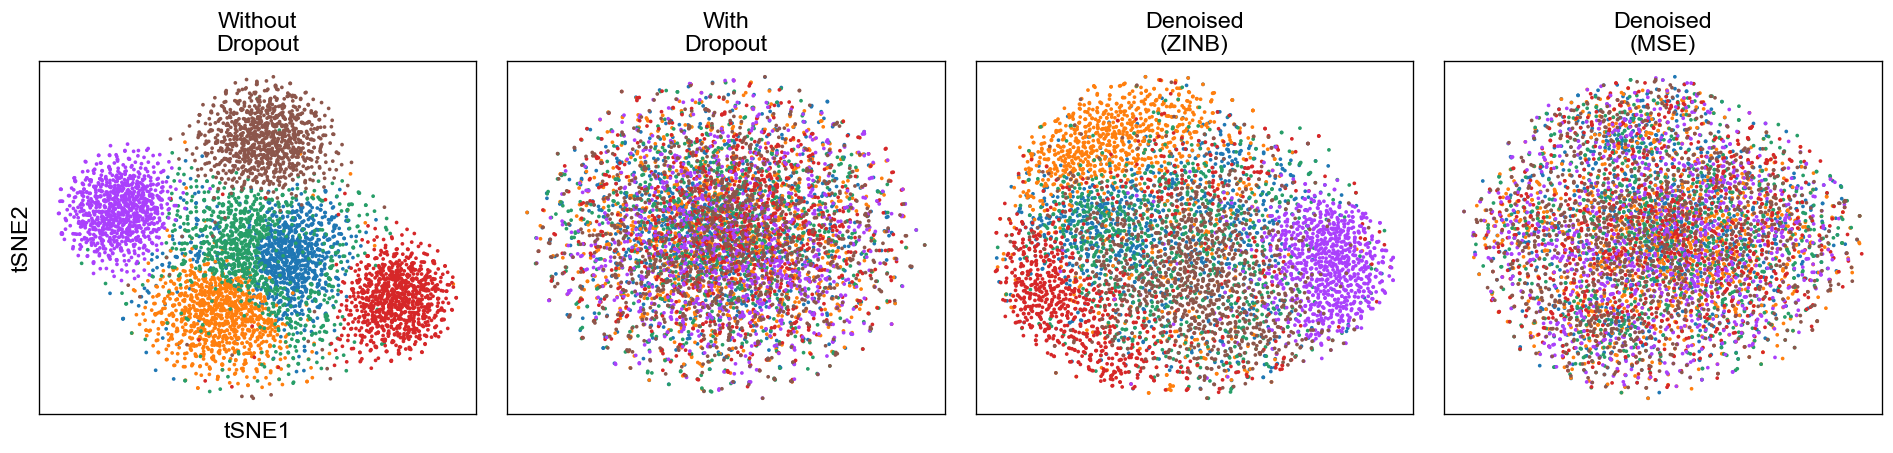

In [24]:
from sklearn.manifold import TSNE

# Compute t-SNE embeddings for each dataset
for ad in [sim_true_norm6, sim_raw_norm6, dca_zinb_norm6, dca_mse_norm6]:
    ad.obsm['X_tsne'] = TSNE(n_components=2, random_state=42).fit_transform(ad.X)

# Define datasets and labels
adatas6 = [sim_true_norm6, sim_raw_norm6, dca_zinb_norm6, dca_mse_norm6]
adata_labels6 = ['Without\nDropout', 'With\nDropout', 'Denoised\n(ZINB)', 'Denoised\n(MSE)']

# Create t-SNE plots
fig, axs = plt.subplots(1, len(adatas6), figsize=(16, 4))
for i, (lbl, ad, ax) in enumerate(zip(adata_labels6, adatas6, axs)):
    sc.pl.scatter(ad, basis='tsne', color='Group', size=20, title=lbl, ax=ax, show=False, legend_loc='none')
    if i != 0:
        ax.set_xlabel('')
        ax.set_ylabel('')

plt.tight_layout()

C:\Users\maygb\AppData\Local\Temp\ipykernel_948\348701672.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + adata_labels6)


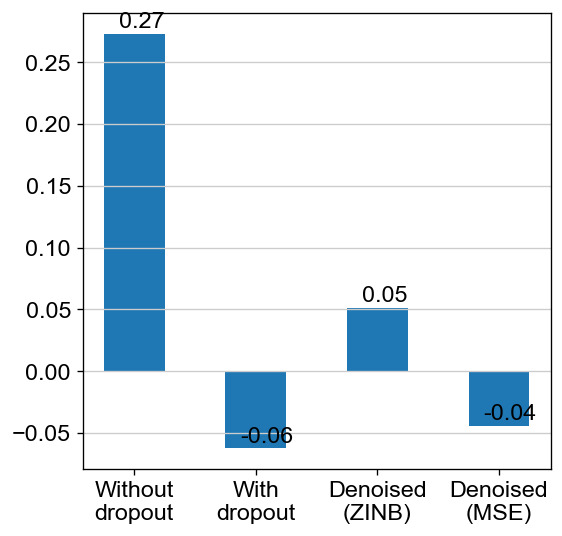

In [22]:
from sklearn.metrics import silhouette_score
sils6 = np.array([silhouette_score(ad.obsm['X_umap'], 
                 ad.obs.Group) for ad in adatas6])

f, ax = plt.subplots(figsize=(5,5))
ax.grid(axis='x')

# Choose the width of each bar and their positions
width = 5
x_pos = [10,20,30,40]
 
# Make the plot
ax.bar(x_pos, sils6, width=width)
ax.set_xticklabels([''] + adata_labels6)

for x, t in zip(x_pos, sils6):
    ax.text(x-1.3, t+0.005, '%.2f' % t)

C:\Users\maygb\miniconda3\envs\new_env\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


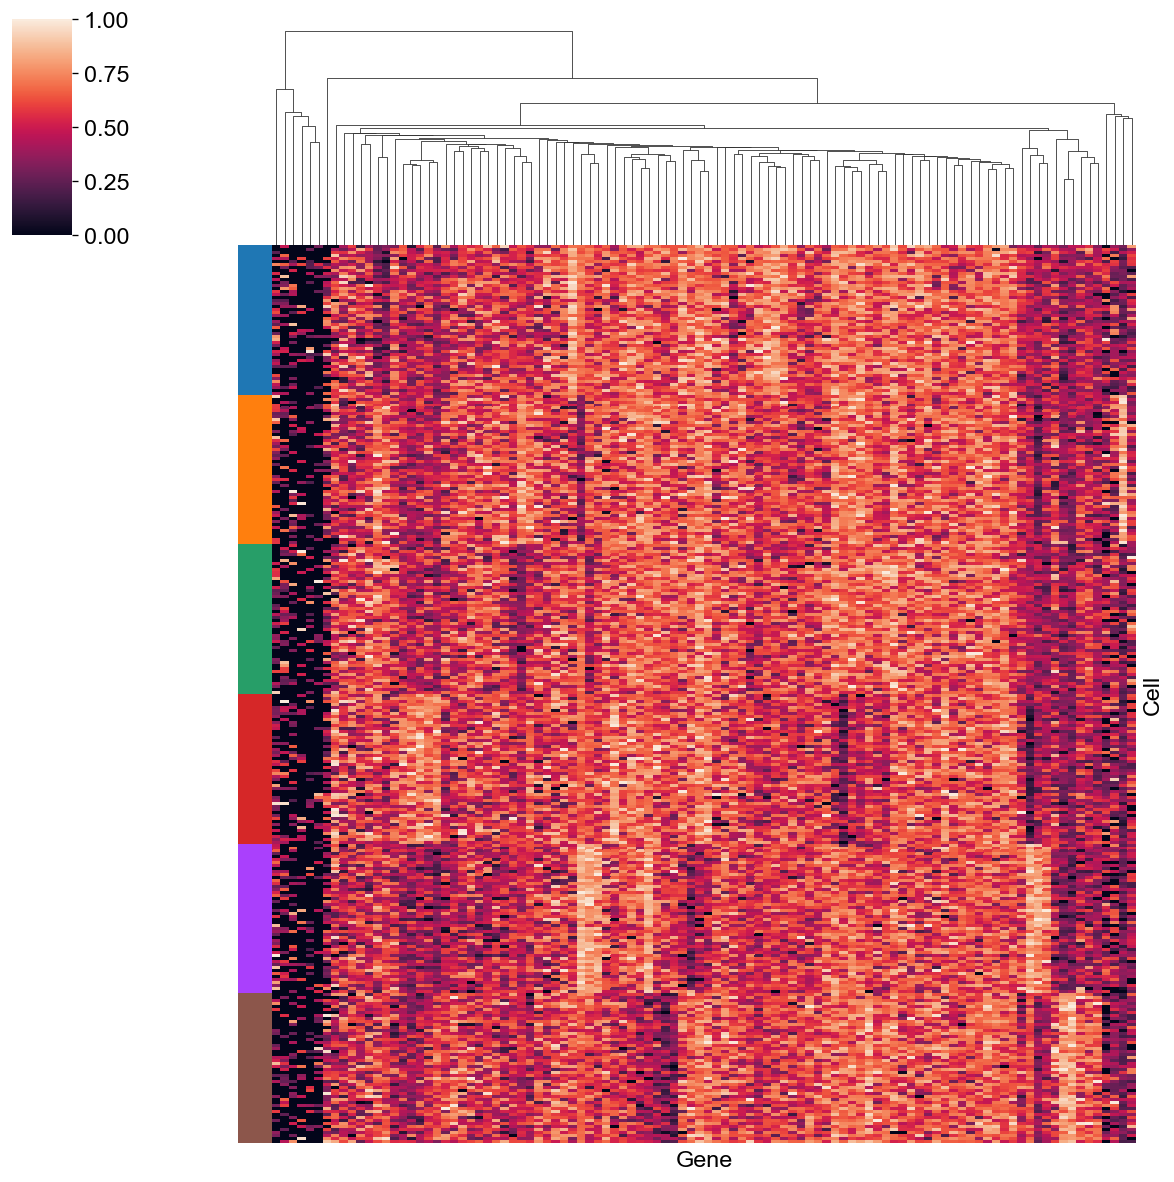

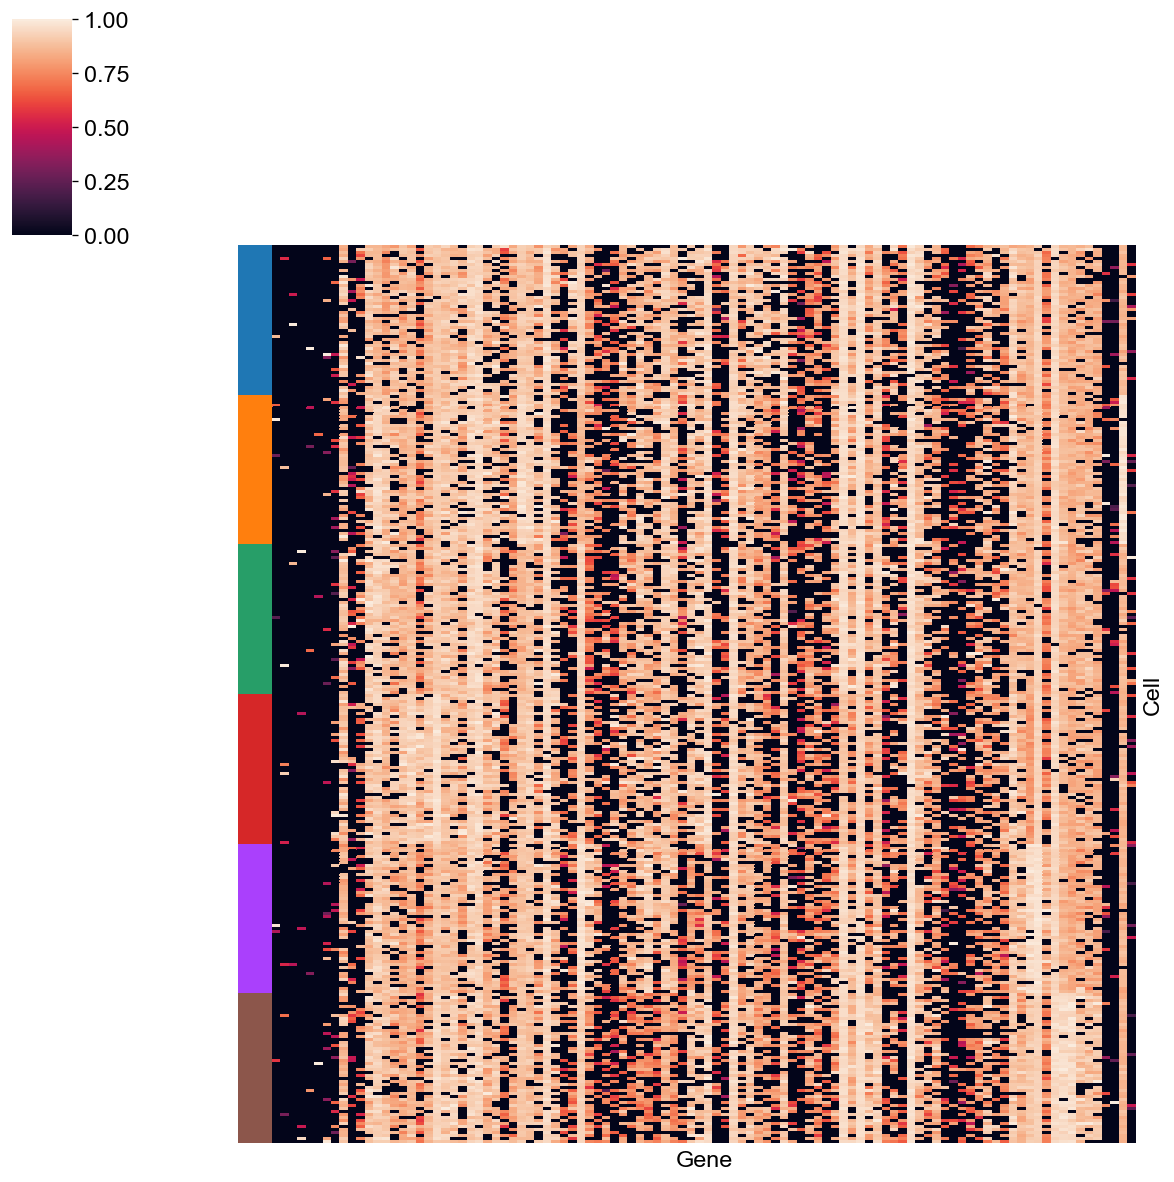

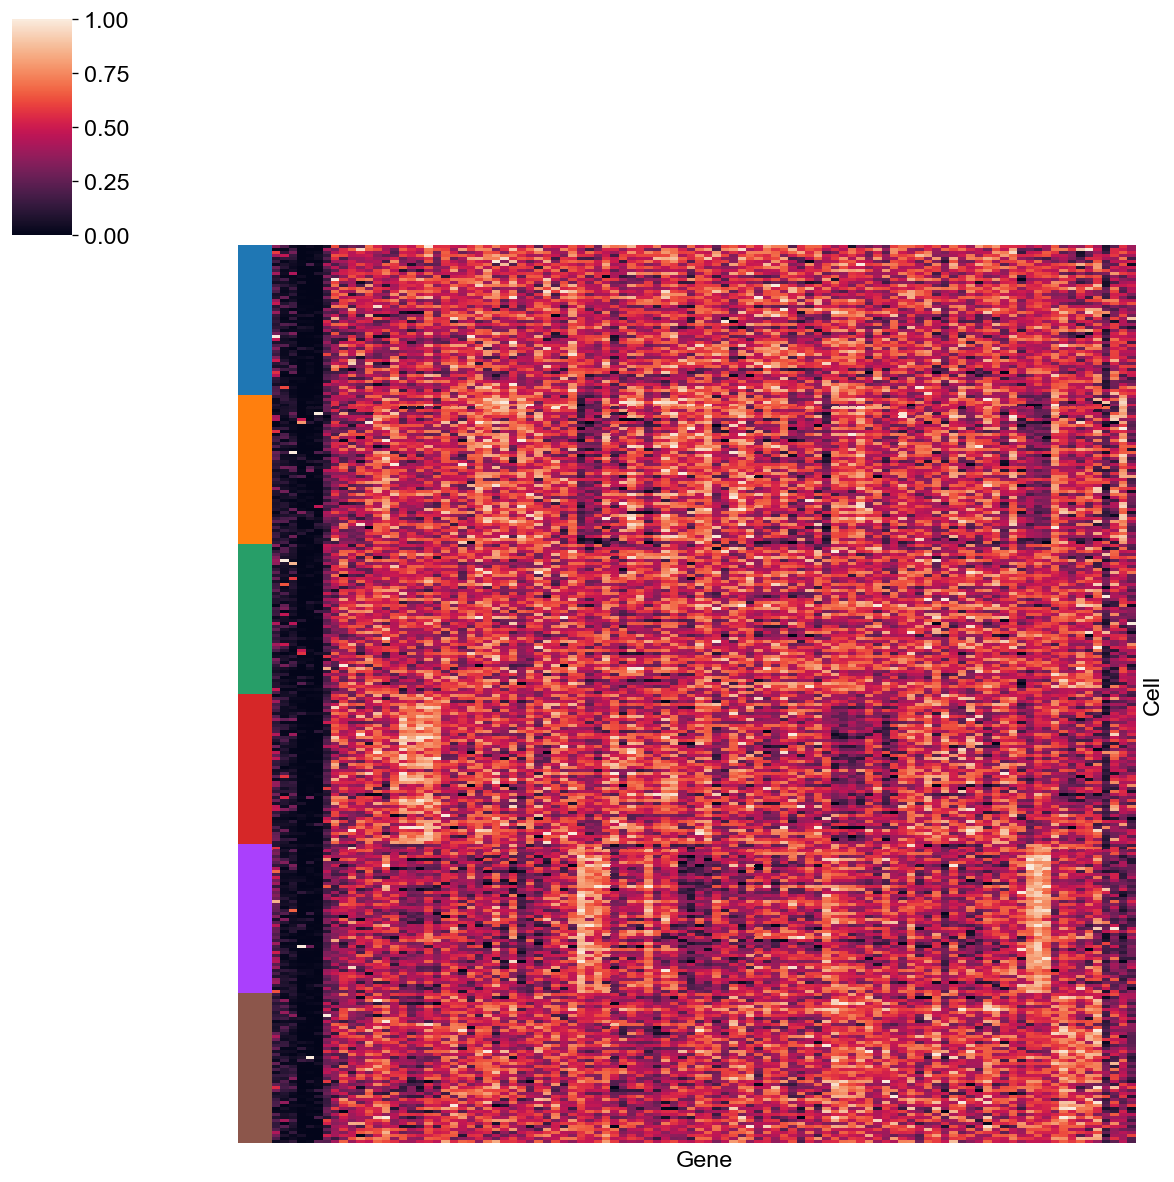

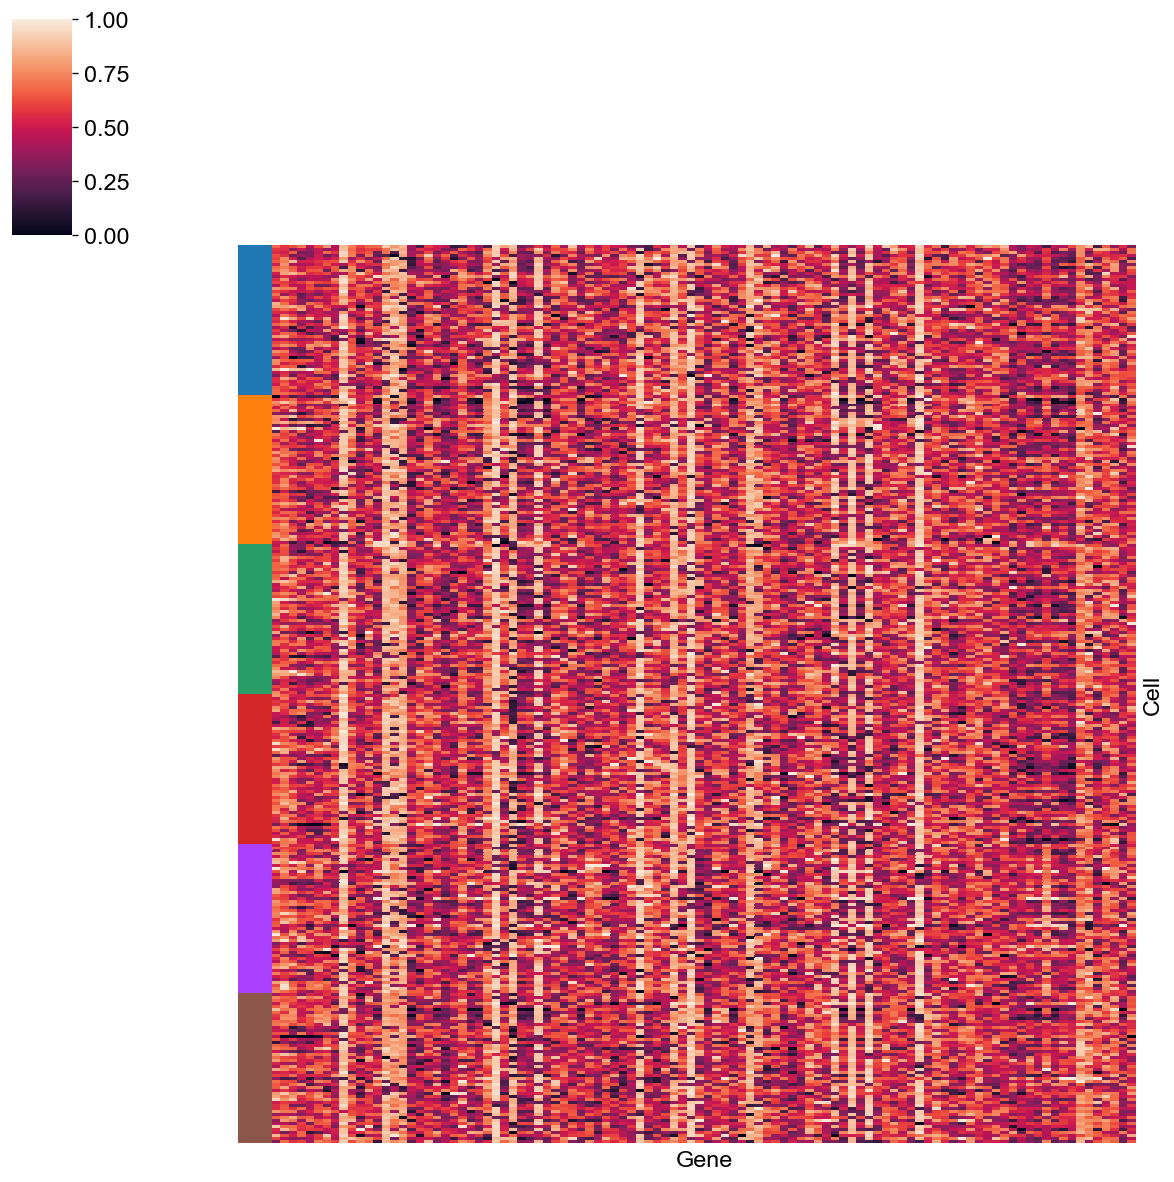

In [23]:
de_genes = np.where(sim_true_norm6.var.loc[:, 'DEFacGroup1':'DEFacGroup6'].values.sum(1) != 6.0)[0]

# stratified sampling
total_samples = 300
total_cats = len(sim_true_norm6.obs.Group.cat.categories)
obs_idx = []
for c in sim_true_norm6.obs.Group.cat.categories:
    obs_idx.extend(list(np.random.choice(list(np.where(sim_true_norm6.obs.Group == c)[0]), 
                                         total_samples//total_cats, 
                                         replace=False)))

ax = sc.pl.clustermap(sim_true_norm6[obs_idx, de_genes], 'Group', use_raw=False,
                      standard_scale=1, row_cluster=False, show=False, xticklabels=False, yticklabels=False)

gene_order = ax.dendrogram_col.reordered_ind # preserve gene order from true counts to make heatmaps comparable
de_genes = de_genes[gene_order]

ax = sc.pl.clustermap(sim_raw_norm6[obs_idx, de_genes], 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

ax = sc.pl.clustermap(dca_zinb_norm6[obs_idx, de_genes], 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)

ax = sc.pl.clustermap(dca_mse_norm6[obs_idx, de_genes], 'Group', use_raw=False, 
                      standard_scale=1, row_cluster=False, col_cluster=False, show=False, xticklabels=False, yticklabels=False)